# Interpolation by matrix completion

We try to solve the following problem:

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{d}-\mathbf{RX}||_2^2 + \mu ||\mathbf{X}||_*
$$

where $||\mathbf{X}||_*=\sum_i \sigma_i$ is the nuclear norm of $\mathbf{X}$ (i.e., sum of eigenvalues).

We are going to:

- truncated SVD (crude approx)
- solve using proximal gradient
- solve using TwIST

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

## FOM Solver example

Example 2 in https://www.tau.ac.il/~becka/adlpmm

In [2]:
np.random.seed(314)

# Create X
n = 40
r = 4
X0 = np.random.randn(n,r);
X1 = np.random.randn(r,n);
X = X0 @ X1

# Create b
p = 0.8
a = int(np.floor(n**2*p))
sample = np.sort(np.random.permutation(np.arange(n**2))[:a])

b = X.ravel()[sample]
Rop = Restriction(n**2, sample)

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.AffineSet.AffineSet'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.000000e+00	niter = 150

   Itn       x[0]          f           g       J = f + g
     1   1.36268e+00   1.000e+00   2.537e+02   2.547e+02
     2   1.36268e+00   1.000e+00   2.269e+02   2.279e+02
     3   1.36268e+00   1.000e+00   2.160e+02   2.170e+02
     4   1.36268e+00   1.000e+00   2.068e+02   2.078e+02
     5   1.36268e+00   1.000e+00   1.991e+02   2.001e+02
     6   1.36268e+00   1.000e+00   1.931e+02   1.941e+02
     7   1.36268e+00   1.000e+00   1.875e+02   1.885e+02
     8   1.36268e+00   1.000e+00   1.823e+02   1.833e+02
     9   1.36268e+00   1.000e+00   1.778e+02   1.788e+02
    10   1.36268e+00   1.000e+00   1.740e+02   1.750e+02
    16   1.36268e+00   1.000e+00   1.610e+02   1.620e+02
    31   1.36268e+00   1.000e+00   1.551e+02   1.561e+02
    46   1.36268e+00  

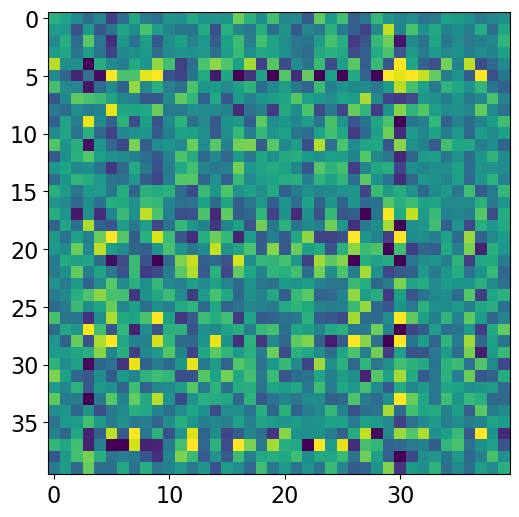

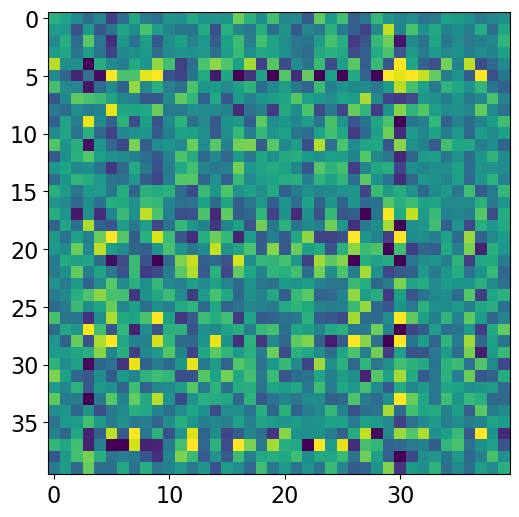

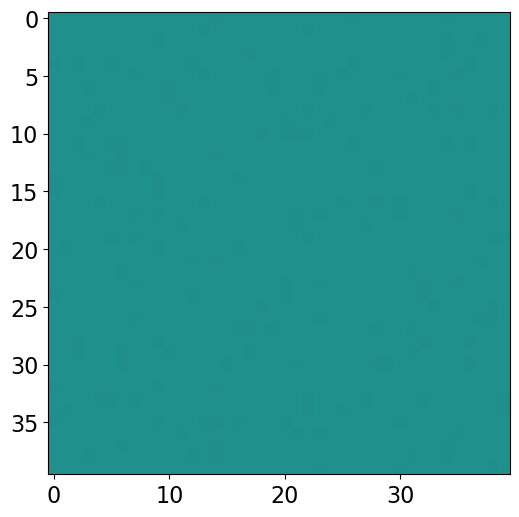

In [3]:
# Reconstruction by low-rank completion
mu = 1.
#f = L2(Rop, b)
f = AffineSet(Rop, b, 10)
g = Nuclear((n, n), mu)

Xpg = ADMM(f, g, np.zeros(n**2), tau=1., niter=150, show=True)[0]
Xpg = Xpg.reshape(n, n)

print(np.linalg.norm(X-Xpg))

plt.figure()
plt.imshow(X, vmin=-5, vmax=5)

plt.figure()
plt.imshow(Xpg, vmin=-5, vmax=5)

plt.figure()
plt.imshow(X-Xpg, vmin=-5, vmax=5);

## 2D image reconstruction

Data and operators preparation

In [4]:
# Load image
X = misc.ascent()
X = X/np.max(X)
ny, nx = X.shape

In [5]:
# Restriction operator
n = ny*nx 
sub = 0.4
nsub = int(n*sub)
iava = np.random.permutation(np.arange(ny*nx))[:nsub]

Rop = Restriction(ny*nx, iava)
y = Rop * X.ravel()

# Masked data
Y = (Rop.H * Rop * X.ravel()).reshape(ny, nx)

### Low-rank completion with t-SVD

In [6]:
# SVD of true and masked data
Ux, Sx, Vhx = np.linalg.svd(X, full_matrices=False)
Uy, Sy, Vhy = np.linalg.svd(Y, full_matrices=False)

# Reconstruction by truncated SVD
U, S, Vh = np.linalg.svd(X, full_matrices=False)
S[S<0.02*S.max()] = 0 
Xsvd = np.dot(U * S, Vh)
print(np.sum(S))

701.74924357387


### Low-rank completion with proximal gradient

In [7]:
# Reconstruction by low-rank completion
mu = .8
f = L2(Rop, y)
g = Nuclear((ny, nx), mu)

#Xpg = ProximalGradient(f, g, np.zeros(ny*nx), tau=1., niter=100, show=True)
#Xpg = Xpg.reshape(ny, nx)

Xpg = AcceleratedProximalGradient(f, g, np.zeros(ny*nx), tau=1., niter=100, show=True)
Xpg = Xpg.reshape(ny, nx)

#Xpg = ADMM(f, g, np.zeros(ny*nx), tau=1., niter=100, show=True)[0]
#Xpg = Xpg.reshape(ny, nx)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1   3.03220e-01   9.785e+01   1.315e+03   1.413e+03
     2   3.00085e-01   9.654e+01   1.224e+03   1.321e+03
     3   2.97050e-01   9.384e+01   1.130e+03   1.224e+03
     4   3.02785e-01   9.026e+01   1.036e+03   1.126e+03
     5   3.03403e-01   8.658e+01   9.445e+02   1.031e+03
     6   3.03331e-01   8.314e+01   8.568e+02   9.400e+02
     7   3.09331e-01   8.026e+01   7.743e+02   8.546e+02
     8   3.10958e-01   7.794e+01   6.991e+02   7.771e+02
     9   3.12015e-01   7.650e+01   6.332e+02   7.097e+02
    10   3.16624e-01   7.547e+01   5.796e+02   6.550e+02
    11   3.18663e-01   7.494e+01   5.397e+02   6.146e+02
    21   3.25326e-01   7.469e+01

In [8]:
# recompute SVD and see how the eigenvalues look like
Upg, Spg, Vhpg = np.linalg.svd(Xpg, full_matrices=False)
print(np.sum(Spg))

606.4111721929015


### Low-rank completion with Twist

In [9]:
# Reconstruction by low-rank completion
mu = .3
g = Nuclear((ny, nx), mu)

emin = 1e-2
emax = 1
k = emin / emax
rho =  (1 - sqrt(k)) / (1 + sqrt(k))
alpha = 1 + rho ** 2
beta = 2 * alpha / (emax + emin)
print(alpha, beta)

Xtw = TwIST(g, Rop, y, np.zeros(ny*nx), alpha=alpha, beta=beta, niter=100, show=True)
Xtw = Xtw.reshape(ny, nx)

1.6694214876033056 3.305785123966942
TwIST
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
Linear operator (A): <class 'pylops.basicoperators.restriction.Restriction'>
alpha = 1.669421e+00	beta = 3.305785e+00	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   5.27360e-01   2.988e+03   8.929e+02   3.881e+03
     2  -3.30935e-02   9.604e+03   2.340e+02   9.838e+03
     3   7.30896e-01   1.298e+04   1.154e+03   1.414e+04
     4  -1.14127e-01   1.682e+04   5.702e+02   1.739e+04
     5   7.71968e-01   1.638e+04   1.155e+03   1.754e+04
     6  -1.07591e-01   1.691e+04   6.845e+02   1.759e+04
     7   7.25199e-01   1.456e+04   1.041e+03   1.560e+04
     8  -4.35799e-02   1.346e+04   6.858e+02   1.415e+04
     9   6.60210e-01   1.094e+04   9.023e+02   1.184e+04
    10   2.36128e-02   9.502e+03   6.281e+02   1.013e+04
    11   6.26810e-01   7.387e+03   7.707e+02   8.158e+03
    21   4.6715

721.9910963491523


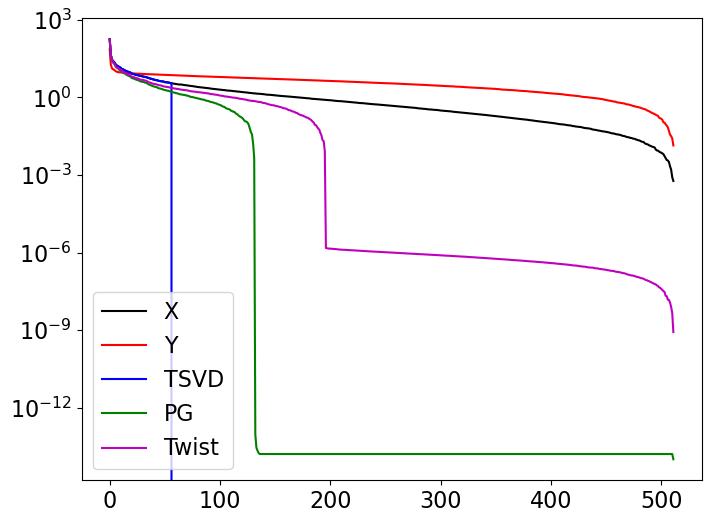

In [10]:
# recompute SVD and see how the eigenvalues look like
Utw, Stw, Vhtw = np.linalg.svd(Xtw, full_matrices=False)
print(np.sum(Stw))

plt.figure()
plt.semilogy(Sx, 'k', label='X')
plt.semilogy(Sy, 'r', label='Y')
plt.semilogy(S, 'b', label='TSVD')
plt.semilogy(Spg, 'g', label='PG')
plt.semilogy(Stw, 'm', label='Twist')
plt.legend();

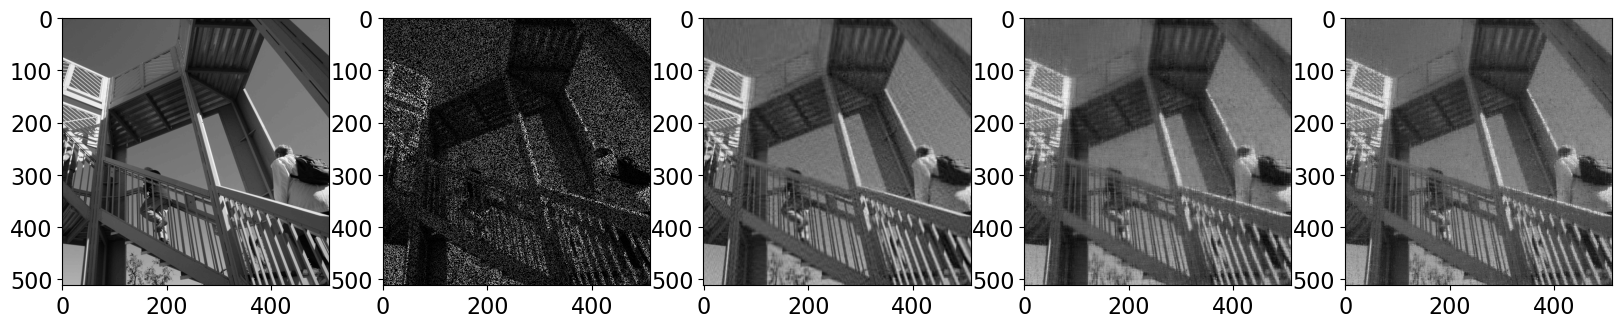

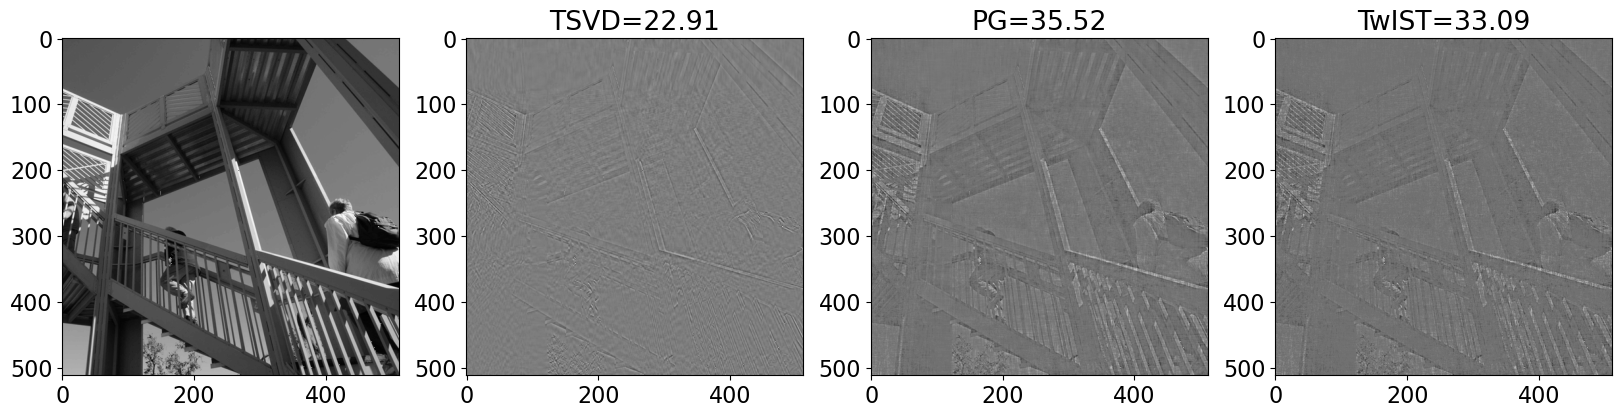

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))
axs[0].imshow(X, cmap='gray')
axs[1].imshow(Y, cmap='gray')
axs[2].imshow(Xsvd, cmap='gray')
axs[3].imshow(Xpg, cmap='gray')
axs[4].imshow(Xtw, cmap='gray')

fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(X, cmap='gray')
axs[1].imshow(X-Xsvd, cmap='gray')
axs[1].set_title('TSVD=%.2f' % np.linalg.norm(X-Xsvd))
axs[2].imshow(X-Xpg, cmap='gray')
axs[2].set_title('PG=%.2f' % np.linalg.norm(X-Xpg))
axs[3].imshow(X-Xtw, cmap='gray')
axs[3].set_title('TwIST=%.2f' % np.linalg.norm(X-Xtw));